In [6]:
import requests
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from emd.sift import sift
from sklearn.preprocessing import StandardScaler

In [7]:
scale = StandardScaler()

In [8]:
asset = 'BTC'

In [9]:
def getPCA(m):
    """
    Gets the Eigenvalues and Eigenvector values from the Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation Matrix
    Returns:
        (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation Matrix
            np.ndarray: Eigenvectors of correlation Matrix
    """
    # Get eVal, eVec from a Hermitian Matrix
    eVal, eVec = np.linalg.eigh(m)
    indicies = eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal, eVec = eVal[indicies], eVec[:, indicies]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [118]:
def emd_pca(p):
    p_scaled = scale.fit_transform(p.reshape(-1,1))
    imf = sift(p_scaled)
    cov = np.cov(imf.T)
    vals, vecs = getPCA(cov)

    # get explained variance
    sum_eig_val = np.sum(vals)
    explained_var = vals / sum_eig_val
    var_percent = np.round(np.diag(explained_var),1)*100
    n_comps = np.count_nonzero(var_percent)
   
    reconstruct = np.dot(imf, vecs[:, :n_comps])
    rec = np.dot(reconstruct, vecs[:, :n_comps].T)
    p_reconstructed = scale.inverse_transform(np.sum(rec,1).reshape(-1,1))
    p_reconstructed = p_reconstructed.reshape(1,-1).squeeze()
    
    diff = gemini_p - p_reconstructed
    
    return diff

In [119]:
# load gemini data
secret_key = "BAxYeS5iigF6M9eRqUv3guVLq35"
gemini_base = "https://api.gemini.com"

gemini_candle = requests.get(gemini_base + "/v2" + "/candles/"+asset+"usd/1m")

In [120]:
gemini_p = np.array(gemini_candle.json())[:,4]

In [121]:
diff = emd_pca(gemini_p)

In [122]:
threshold = diff.std() * 1

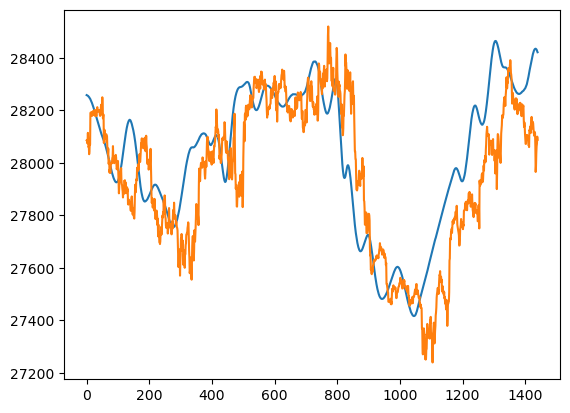

In [123]:
plt.plot(p_reconstructed)
plt.plot(gemini_p)

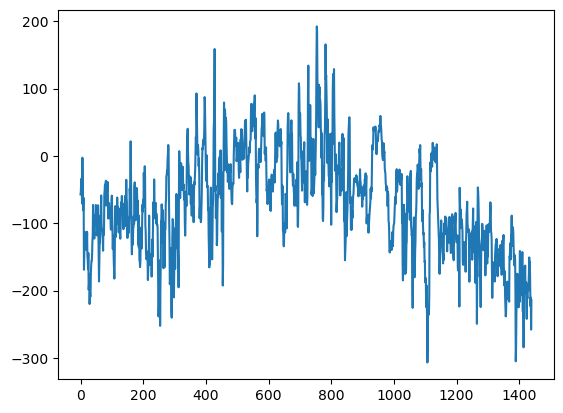

In [67]:
plt.plot(diff)

In [109]:
diff

array([ -57.25372134,  -53.55818375,  -38.56868362, ..., -210.51018171,
       -258.00598396, -214.33619093])

In [105]:
positions = np.zeros_like(gemini_p)
buy = True
for i in range(len(diff)):
    if diff[i] < 0:
        if abs(diff[i]) > threshold and buy:
            # place buy order
            positions[i] = 1
            buy = False
    if diff[i] > 0:
        if diff[i] > threshold and not buy:
            # place sell order
            positions[i] = -1
            buy = True

In [106]:
positions*gemini_p

array([0., 0., 0., ..., 0., 0., 0.])

In [107]:
positions_all = positions[np.nonzero(positions*gemini_p)]
p_all = gemini_p[np.nonzero(positions*gemini_p)]
ls = (positions_all*p_all)

In [108]:
ls[:-1:2] + ls[1::2]

array([ -33.96, -139.77, -129.29, -253.39, -221.7 , -218.71, -119.54])

array([28203.62])

In [18]:
shares = 1
transaction_costs = 0.01

In [27]:
trades = positions[positions != 0]

In [28]:
if len(trades) % 2 != 0:
    trades = trades[1:]

In [29]:
pnl = np.sum(shares*-trades)

In [30]:
pnl

2185.4800000000505